In [6]:
from qiskit_nature.units import *   #ANGSTROM
from qiskit_nature.second_q.drivers import *    #PySCFDriver
from qiskit_nature.second_q.mappers import * #JordanWignerMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.problems import EigenstateResult
from qiskit_nature.second_q.circuit.library import *  #Ansatz, HF
#from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator, Options
from qiskit_algorithms.optimizers import * 
from qiskit_algorithms import VQE
from braket.tracking import Tracker
from qiskit_braket_provider import *
from qiskit_aer import StatevectorSimulator
from qiskit.primitives import Estimator
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

import numpy as np

In [7]:
def h2_padrao(d,mapper = BravyiKitaevMapper()):

    driver = PySCFDriver(atom=f"H 0 0 0; H 0 0 {d}", basis="sto-3g")
    estrutura_otimizada = driver.run() #Criamos a estrutura do nosso sistema

    ansatz = UCCSD(
        estrutura_otimizada.num_spatial_orbitals,
        estrutura_otimizada.num_particles,
        mapper,
        initial_state=HartreeFock(
            estrutura_otimizada.num_spatial_orbitals,
            estrutura_otimizada.num_particles,
            mapper))


    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters
    calculo = GroundStateEigensolver(mapper, vqe_solver)
    resultados = calculo.solve(estrutura_otimizada)

    return [resultados.groundenergy + resultados.nuclear_repulsion_energy, resultados.groundenergy, resultados.nuclear_repulsion_energy]

In [23]:
def h2_active_space(d,mapper = BravyiKitaevMapper()):

    driver = PySCFDriver(atom=f"H 0 0 0; H 0 0 {d}", basis="sto-3g")
    estrutura_inicial = driver.run() #Criamos a estrutura do nosso sistema

    espaco_target = ActiveSpaceTransformer(2,2) #Active Space para o H2
    estrutura_otimizada = espaco_target.transform(estrutura_inicial) #mudando nossa hamiltoniana para o active space


    ansatz = UCCSD(
        estrutura_otimizada.num_spatial_orbitals,
        estrutura_otimizada.num_particles,
        mapper,
        initial_state=HartreeFock(
            estrutura_otimizada.num_spatial_orbitals,
            estrutura_otimizada.num_particles,
            mapper))


    vqe_solver = VQE(Estimator(), ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters
    calculo = GroundStateEigensolver(mapper, vqe_solver)
    resultados = calculo.solve(estrutura_otimizada)

    return [resultados.groundenergy + resultados.nuclear_repulsion_energy, resultados.groundenergy, resultados.nuclear_repulsion_energy]

In [13]:
intervalo = np.concatenate((np.linspace(0.2,2.5,15), np.linspace(2.5,5,5)))


In [14]:
diferenca = np.array(h2_active_space(d=20))
dados = [np.array(h2_active_space(a)) - diferenca for a in intervalo]
PES = [dados[i][0] for i in range(len(dados))]

In [15]:
diff = np.array(h2_padrao(d=20))
dados_teste = [np.array(h2_padrao(a)) - diff for a in intervalo]
PES_teste = [dados_teste[i][0] for i in range(len(dados_teste))]

In [16]:
gse = [dados_teste[i][1] for i in range(len(dados_teste))]
nuclear = [dados_teste[i][2] for i in range(len(dados_teste))]

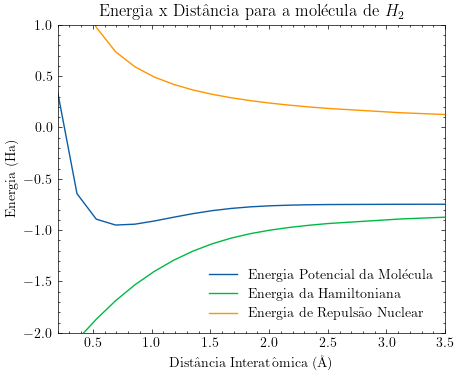

In [37]:
import matplotlib.pyplot as plt
plt.style.use('science')
#with plt.style.context("science"):

a = plt.figure()
a.set_figwidth(5)
a.set_figheight(4)
plt.xlim(0.2,3.5)
plt.ylim(-2,1)
plt.plot(intervalo,PES_teste, label = 'Energia Potencial da Molécula')
plt.plot(intervalo,gse, label = 'Energia da Hamiltoniana')
plt.plot(intervalo, nuclear, label = 'Energia de Repulsão Nuclear')
plt.xlabel('Distância Interatômica (Å)')
plt.ylabel('Energia (Ha)')
plt.title('Energia x Distância para a molécula de $H_2$')
plt.legend()
plt.show()


In [17]:
driver = PySCFDriver(atom="O 0 0 -1.16; C 0 0 0; O 0 0 1.16", basis="sto-3g")
pre_problem = driver.run() #Criamos a estrutura do nosso sistema

target = ActiveSpaceTransformer(8,8) #Active Space para o CO2
problem = target.transform(pre_problem) #mudando nossa hamiltoniana para o active space

mapper =  BravyiKitaevMapper()




In [21]:
#padrão
print(pre_problem.num_spatial_orbitals)
print(pre_problem.num_spin_orbitals)

15
30


In [22]:
#active space
print(problem.num_spatial_orbitals)
print(problem.num_spin_orbitals)

8
16


In [ ]:
print()

In [ ]:
ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper))


vqe_solver = VQE(Estimator(), ansatz, SLSQP())
vqe_solver.initial_point = [0.0] * ansatz.num_parameters